## Liberaries

In [36]:
import pandas as pd
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tqdm import tqdm
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

## Loading the dataset

In [37]:
df = pd.read_csv('./training.1600000.processed.noemoticon.csv', header=None, encoding='latin')

df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


## Preprocessing & Data Cleaning

1. Rename the required columns

In [38]:
df.rename(columns={
    0:'Sentiment',
    5:'Tweets'
}, inplace=True)

df.head()

,Sentiment,1,2,3,4,Tweets
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


2. Remove unnessery columns

In [39]:
df.drop([1,2,3,4], axis=1, inplace=True)

df.head()

,Sentiment,Tweets
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


3. Replace 4 with 1 that reflects Positive sentiment

In [40]:
df['Sentiment'].unique()

array([0, 4], dtype=int64)

In [41]:
df['Sentiment'][df['Sentiment'] == 4] = 1

df['Sentiment'].unique()

array([0, 1], dtype=int64)

4. Getting a portion of the dataset as the whole dataset is huge

In [42]:
df = df.sample(frac=1).reset_index(drop=True)

df = df[:10000]

df.head()

,Sentiment,Tweets
0,1,@aaronasay I'm so happy that you'll keep the f...
1,0,@cmeahan what happened?
2,1,"@neridah ooh, I did that 8 years ago. What a b..."
3,0,@Lindz_theWriter YAY happy bday twin sorry for...
4,0,"Bestfriend just left probably cleaning, then ..."


In [43]:
df.shape

(10000, 2)

In [44]:
df['Sentiment'].value_counts()

Sentiment
1    5008
0    4992
Name: count, dtype: int64

5. Data Cleaning ***

In [45]:
tweets = df['Tweets'].values

tweets

array(["@aaronasay I'm so happy that you'll keep the faith ",
       '@cmeahan what happened? ',
       '@neridah ooh, I did that 8 years ago. What a blast when you get over though ',
       ...,
       '@danbimrose hi!  i am a hippie.a writer..ve had anxiety a few times..ive got babyboomer parents.n i really like your backround for yur pg',
       '@purityring check obnoxious  and sign on in like..3 hours cause i gotta go to school rn',
       "YESSS! annie's going to warped for suuureee nowww.  so now i have a pit partnerrr!"],
      dtype=object)

In [46]:
cleaned_tweets = []
lemmatization = WordNetLemmatizer()

for tweet in tqdm(tweets):
    # convert into lower case
    tweet = tweet.lower()
    # remove links
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet)
    # remove @
    tweet = re.sub(r'@\S+', '', tweet)
    # remove special characters
    tweet = re.sub(r'[^\w\s#]', '', tweet)
    # lemmatize each word
    tweet = [lemmatization.lemmatize(word) for word in word_tokenize(tweet)]
    # remove stop words
    tweet = [word for word in tweet if word not in stopwords.words('english')]

    # processed tweet
    processed_tweet = ' '.join(tweet)

    cleaned_tweets.append(processed_tweet)

cleaned_tweets[:50]

  0%|          | 6/10000 [00:00<02:51, 58.25it/s]

100%|██████████| 10000/10000 [00:25<00:00, 388.47it/s]


['im happy youll keep faith',
 'happened',
 'ooh 8 year ago blast get though',
 'yay happy bday twin sorry late response yay bday time',
 'bestfriend left probably cleaning grandma brother',
 'added thank',
 'bleurgh illness definitely acting probably gon na go flump friend soon',
 'martin',
 'hope quotitalianquot coffee',
 'haha yeaah omg got butterfly im excited aaaaaah',
 'beautiful day lot fun elli island liberty island today',
 'dance wa awesome rent goe night home alone call text 6033937942 lt3party yesnomaybe',
 'watchin corrie lovin sun',
 'im tire though know granddaughter wa 230am 45 minute next fuss',
 'deleted sirius presets must redone',
 'sigh olive garden till 11 movie 12 slept whole time wa funny though sleepy cousin couch gnite yall',
 'concert wa heartwarming experience long time thanks much feist guy',
 'problem want tweet video shooting studio',
 'oh glastonbury sort life someone haha',
 'preparing drive vienna via salzburg wifey wont let drive',
 'joining twitter',

6. Add two new columns

In [47]:
def word_count(text):
    return len(text.split())

def character_count(text):
    return len(text)

df['Cleaned_Tweets'] = cleaned_tweets
df['Word_Count'] = df['Cleaned_Tweets'].apply(word_count)
df['Character_Count'] = df['Cleaned_Tweets'].apply(character_count)

df.head()

,Sentiment,Tweets,Cleaned_Tweets,Word_Count,Character_Count
0,1,@aaronasay I'm so happy that you'll keep the f...,im happy youll keep faith,5,25
1,0,@cmeahan what happened?,happened,1,8
2,1,"@neridah ooh, I did that 8 years ago. What a b...",ooh 8 year ago blast get though,7,31
3,0,@Lindz_theWriter YAY happy bday twin sorry for...,yay happy bday twin sorry late response yay bd...,10,53
4,0,"Bestfriend just left probably cleaning, then ...",bestfriend left probably cleaning grandma brother,6,49


## Creation of Word Cloud

In [48]:
positive_sentiment = df[df['Sentiment']==1].shape[0]
negative_sentiment = df[df['Sentiment']==0].shape[0]

fig = px.pie(values=[positive_sentiment, negative_sentiment],
             names=['Positive Sentiment','Negative Sentiment'],
             hover_name=['Positive Sentiment','Negative Sentiment'],
             opacity=0.8,
             template='simple_white',
             title='Distribution of Sentiments')

fig.show()

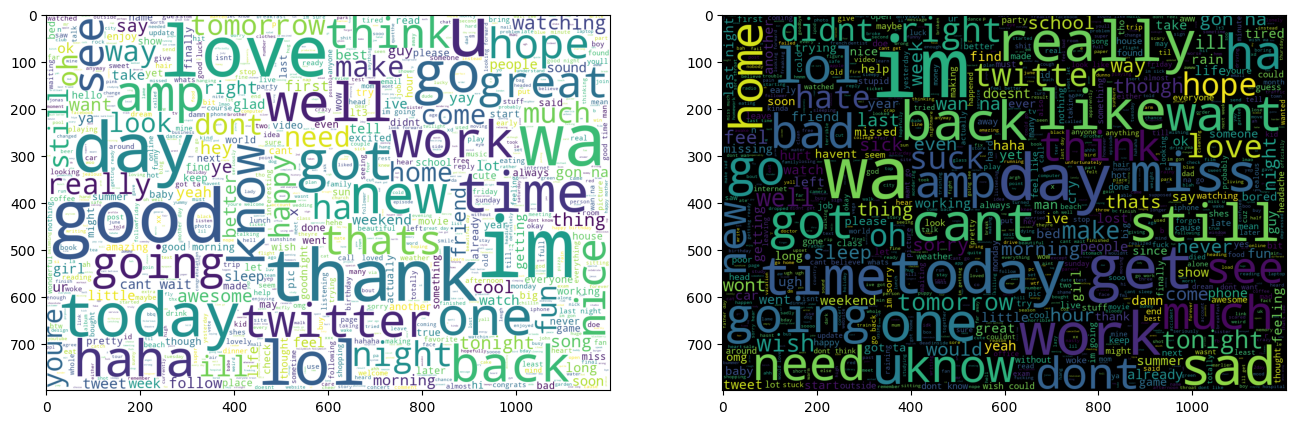

In [49]:
plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
cloud_1 = WordCloud(width=1200, height=800, max_words=1000, contour_width=2,
    background_color='white', max_font_size=180,colormap='viridis').generate(' '.join(df[df['Sentiment']==1]['Cleaned_Tweets']))
plt.imshow(cloud_1)

plt.subplot(1,2,2)
cloud_2 = WordCloud(width=1200, height=800, max_words=1000, contour_width=2,
    background_color='black',stopwords=['good'], max_font_size=180,colormap='viridis').generate(' '.join(df[df['Sentiment']==0]['Cleaned_Tweets']))

plt.imshow(cloud_2)

In [50]:
# Create distribution plots for word count and character count for positive and negative tweets
fig_words = ff.create_distplot(
    [df[df['Sentiment'] == 1]['Word_Count'], df[df['Sentiment'] == 0]['Word_Count']],
    ['Positive', 'Negative'],
    bin_size=25,
    show_hist=False,
    show_rug=False
)

fig_chars = ff.create_distplot(
    [df[df['Sentiment'] == 1]['Character_Count'], df[df['Sentiment'] == 0]['Character_Count']],
    ['Positive', 'Negative'],
    bin_size=25,
    show_hist=False,
    show_rug=False
)

# Set titles and labels for the distribution plots
fig_chars.update_layout(title="Distribution Plot on Character Count", xaxis_title="Number of Characters", yaxis_title="Frequency")
fig_words.update_layout(title="Distribution Plot on Word Count", xaxis_title="Number of Words", yaxis_title="Frequency")

# Combine the plots in a 2-column layout
fig = make_subplots(rows=1, cols=2, subplot_titles=["Word Count", "Character Count"])
fig.add_trace(fig_words['data'][0], row=1, col=1)
fig.add_trace(fig_words['data'][1], row=1, col=1)
fig.add_trace(fig_chars['data'][0], row=1, col=2)
fig.add_trace(fig_chars['data'][1], row=1, col=2)

# Update overall layout and show the plot
fig.update_layout(title_text="Distribution Plots - Word Count vs Character Count", showlegend=True, font=dict(family="Arial", size=15, color="black"))
fig.show()

## Spliting of data

In [51]:
x_train, x_test, y_train, y_test = train_test_split(df['Cleaned_Tweets'],df['Sentiment'],test_size=0.2, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

print(x_train.shape, y_train.shape)
print(y_test.shape, y_test.shape)
print(x_val.shape, y_val.shape)

(8000,) (8000,)
(1000,) (1000,)
(1000,) (1000,)


In [52]:
fig = px.pie(values=[x_train.shape[0], x_test.shape[0], x_val.shape[0]],
        names=['Train Data','Test Data','Validate Data'],
        hover_name=['Train Data','Test Data','Validate Data'],
        title="Spliting of data",
        opacity=0.9,
        template='simple_white')

fig.show()

## <font color = "Green">Model Creation</font>

In [53]:
def sigmoid_function(values):
    ans = []
    
    for val in values:
        ans.append(1 if val >= 0.5 else 0)

    return ans

In [54]:
e_pochs = 10
batch_size = 64

1. One hot Encoding (Basic)

In [55]:
one_hot = CountVectorizer(binary=True)

one_hot.fit(df['Cleaned_Tweets'])

enc_tweets = one_hot.transform(df['Cleaned_Tweets']).toarray()

enc_tweets

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [56]:
enc_tweets.shape

(10000, 14137)

In [57]:
x_train, x_test, y_train, y_test = train_test_split(enc_tweets, df['Sentiment'], test_size=0.2, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(x_val.shape, y_val.shape)

(8000, 14137) (8000,)
(1000, 14137) (1000,)
(1000, 14137) (1000,)


In [58]:
# choosing type of model
model = Sequential()

# input layer
model.add(Dense(2048, activation = 'relu', input_shape = (enc_tweets.shape[1],)))

# hidden layer
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.5))

# output layer
model.add(Dense(1, activation = 'sigmoid'))

# compiling the model
model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate = 0.0001), metrics=['accuracy'])

# printing model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 2048)              28954624  
                                                                 
 dense_11 (Dense)            (None, 512)               1049088   
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_12 (Dense)            (None, 128)               65664     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 32)                4128      
                                                                 
 dropout_8 (Dropout)         (None, 32)               

In [59]:
# model train
model.fit(x_train, y_train, epochs=e_pochs, batch_size=batch_size, validation_data=(x_val, y_val))

Epoch 1/10
125/125 [==============================] - 43s 327ms/step - loss: 0.6917 - accuracy: 0.5205 - val_loss: 0.6895 - val_accuracy: 0.5040
Epoch 2/10
125/125 [==============================] - 40s 318ms/step - loss: 0.6656 - accuracy: 0.6251 - val_loss: 0.6326 - val_accuracy: 0.6930
Epoch 3/10
125/125 [==============================] - 39s 316ms/step - loss: 0.5161 - accuracy: 0.7807 - val_loss: 0.5625 - val_accuracy: 0.7250
Epoch 4/10
125/125 [==============================] - 39s 314ms/step - loss: 0.2873 - accuracy: 0.9013 - val_loss: 0.6540 - val_accuracy: 0.7170
Epoch 5/10
125/125 [==============================] - 39s 314ms/step - loss: 0.1402 - accuracy: 0.9601 - val_loss: 0.8397 - val_accuracy: 0.7020
Epoch 6/10
125/125 [==============================] - 39s 314ms/step - loss: 0.0697 - accuracy: 0.9814 - val_loss: 1.0454 - val_accuracy: 0.6980
Epoch 7/10
125/125 [==============================] - 39s 315ms/step - loss: 0.0462 - accuracy: 0.9869 - val_loss: 1.1814 - val_ac

In [60]:
# model test
y_pred = model.predict(x_test)

print("Predicted values :",sigmoid_function(y_pred))
print("Actual values :",y_test.values)

# model accuracy
print("Model evaluation on testing data :",round(model.evaluate(x_test, y_test)[1]*100, 2),"%")

32/32 [==============================] - 1s 16ms/step
Predicted values : [0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,

2. Count Vectorizer (Basic)

In [61]:
count_vec = CountVectorizer(binary=False)
count_vec.fit(df['Cleaned_Tweets'])

enc_tweets = count_vec.transform(df['Cleaned_Tweets']).toarray()

enc_tweets

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [62]:
x_train, x_test, y_train, y_test = train_test_split(enc_tweets,df['Sentiment'],test_size=0.2, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_test,y_test,test_size=0.5, random_state=42)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(x_val.shape, y_val.shape)

(8000, 14137) (8000,)
(1000, 14137) (1000,)
(1000, 14137) (1000,)


In [63]:
model = Sequential()

model.add(Dense(2048, activation = 'relu', input_shape = (enc_tweets.shape[1],)))

model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 2048)              28954624  
                                                                 
 dense_16 (Dense)            (None, 512)               1049088   
                                                                 
 dropout_9 (Dropout)         (None, 512)               0         
                                                                 
 dense_17 (Dense)            (None, 128)               65664     
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 dense_18 (Dense)            (None, 32)                4128      
                                                                 
 dropout_11 (Dropout)        (None, 32)               

In [64]:
model.fit(x_train, y_train, epochs=e_pochs, batch_size=batch_size, validation_data=(x_val, y_val))

Epoch 1/10
125/125 [==============================] - 43s 326ms/step - loss: 0.6903 - accuracy: 0.5194 - val_loss: 0.6884 - val_accuracy: 0.4990
Epoch 2/10
125/125 [==============================] - 40s 320ms/step - loss: 0.6553 - accuracy: 0.6149 - val_loss: 0.6198 - val_accuracy: 0.7000
Epoch 3/10
125/125 [==============================] - 40s 319ms/step - loss: 0.4986 - accuracy: 0.7965 - val_loss: 0.5618 - val_accuracy: 0.7200
Epoch 4/10
125/125 [==============================] - 40s 320ms/step - loss: 0.2801 - accuracy: 0.9125 - val_loss: 0.6605 - val_accuracy: 0.7110
Epoch 5/10
125/125 [==============================] - 41s 329ms/step - loss: 0.1405 - accuracy: 0.9619 - val_loss: 0.8209 - val_accuracy: 0.6970
Epoch 6/10
125/125 [==============================] - 40s 321ms/step - loss: 0.0779 - accuracy: 0.9796 - val_loss: 0.9852 - val_accuracy: 0.7110
Epoch 7/10
125/125 [==============================] - 40s 319ms/step - loss: 0.0496 - accuracy: 0.9870 - val_loss: 1.1902 - val_ac

In [66]:
y_pred = sigmoid_function(model.predict(x_test))
print("Predicted data :",y_pred)
print("Actual data :",y_test.values)

print("Accuracy :",round(model.evaluate(x_test, y_test)[1]*100, 2),"%")

32/32 [==============================] - 1s 17ms/step
Predicted data : [0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0

3. TF-IDF Vectorizer (Basic)

In [68]:
tfidf = TfidfVectorizer()

enc_tweets = tfidf.fit_transform(df['Cleaned_Tweets']).toarray()

enc_tweets

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [69]:
x_train, x_test, y_train, y_test = train_test_split(enc_tweets,df['Sentiment'],test_size=0.2, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_test,y_test,test_size=0.5, random_state=42)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(x_val.shape, y_val.shape)

(8000, 14137) (8000,)
(1000, 14137) (1000,)
(1000, 14137) (1000,)


In [70]:
model = Sequential()

model.add(Dense(2048, activation = 'relu', input_shape = (enc_tweets.shape[1],)))

model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 2048)              28954624  
                                                                 
 dense_21 (Dense)            (None, 512)               1049088   
                                                                 
 dropout_12 (Dropout)        (None, 512)               0         
                                                                 
 dense_22 (Dense)            (None, 128)               65664     
                                                                 
 dropout_13 (Dropout)        (None, 128)               0         
                                                                 
 dense_23 (Dense)            (None, 32)                4128      
                                                                 
 dropout_14 (Dropout)        (None, 32)               

In [71]:
model.fit(x_train, y_train, epochs=e_pochs, batch_size=batch_size, validation_data=(x_val, y_val))

Epoch 1/10
125/125 [==============================] - 43s 334ms/step - loss: 0.6930 - accuracy: 0.5091 - val_loss: 0.6914 - val_accuracy: 0.6380
Epoch 2/10
125/125 [==============================] - 40s 321ms/step - loss: 0.6809 - accuracy: 0.6011 - val_loss: 0.6583 - val_accuracy: 0.7000
Epoch 3/10
125/125 [==============================] - 40s 320ms/step - loss: 0.5380 - accuracy: 0.7804 - val_loss: 0.5725 - val_accuracy: 0.7130
Epoch 4/10
125/125 [==============================] - 40s 321ms/step - loss: 0.2787 - accuracy: 0.9122 - val_loss: 0.6504 - val_accuracy: 0.7030
Epoch 5/10
125/125 [==============================] - 40s 321ms/step - loss: 0.1279 - accuracy: 0.9661 - val_loss: 0.8248 - val_accuracy: 0.6860
Epoch 6/10
125/125 [==============================] - 40s 318ms/step - loss: 0.0706 - accuracy: 0.9815 - val_loss: 0.9403 - val_accuracy: 0.7000
Epoch 7/10
125/125 [==============================] - 40s 318ms/step - loss: 0.0471 - accuracy: 0.9893 - val_loss: 1.0816 - val_ac

In [72]:
y_pred = sigmoid_function(model.predict(x_test))
print("Predicted data :",y_pred)
print("Actual data :",y_test.values)

print("Accuracy :",round(model.evaluate(x_test, y_test)[1]*100, 2),"%")

32/32 [==============================] - 1s 18ms/step
Predicted data : [0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0